In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install polars

In [3]:
from collections import defaultdict, Counter
from typing import List, Dict, Union

from tqdm import tqdm
import polars as pl

In [4]:
WINDOW_N = 10
WEIGHTS = {-10:0.01, -9:0.01, -8:0.01, -7:0.01, -6:0.01, -5:0.05, -4:0.05, -3:0.1, -2:0.25, -1:0.5, 1:3, \
2:0.5, 3:0.25, 4:0.1, 5:0.05, 6:0.01, 7:0.01, 8:0.01, 9:0.01, 10:0.01, }
TOP_N = 200
LOCALES = ["DE", "UK", "JP"]
VER = "25"
DIR = "/content/drive/MyDrive/kddcup2023-ly/kddcup2023/"


In [5]:
def preprocess(df:pl.DataFrame) -> pl.DataFrame:
    df = df.explode(["prev_items"])
    df = df.with_columns(
        df.select(pl.col("session_id").cumcount().over("session_id").alias("sequence_num"))
    )
    return df

In [6]:
def generate_co_visit_matrix(df:pl.DataFrame, window_n:int, weights:Dict[int, float]) -> pl.DataFrame:
    # Creation of co-occurrence pairs
    df = df[["session_id", "prev_items", "sequence_num"]].join(df[["session_id", "prev_items", "sequence_num"]], on="session_id")

    # Calculate the co-occurrence interval and filter
    df = df.with_columns(
        (pl.col("sequence_num_right").cast(pl.Int64) - pl.col("sequence_num").cast(pl.Int64)).alias("diff_sequence_num")
    )
    df = df.filter(pl.col("diff_sequence_num").abs() <= window_n)
    df = df.filter(pl.col("prev_items") != pl.col("prev_items_right"))

    # Calculate the weight and sum for each co-occurrence pair
    df = df.with_columns(
        pl.col("diff_sequence_num").map_dict(weights).alias("co_visit_weight")
    )
    df = df.groupby(["prev_items", "prev_items_right"]).sum()
    df = df.rename({"prev_items":"item", "prev_items_right":"candidate_item"})[["item", "candidate_item", "co_visit_weight"]]

    return df

In [7]:
def filter_by_locale_availability(co_visit_matrix:pl.DataFrame, product:pl.DataFrame):
    product = product.unique(subset=["id"])
    product = product[["id", "available_locales"]]
    co_visit_matrix = co_visit_matrix.join(product, left_on="item", right_on="id", how="left").rename({"available_locales":"item_locales"})
    co_visit_matrix = co_visit_matrix.join(product, left_on="candidate_item", right_on="id", how="left").rename({"available_locales":"candidate_item_locales"})
    dfs = []
    for locale in LOCALES:
        df = co_visit_matrix.filter(pl.lit(locale).is_in(pl.col("item_locales")) & pl.lit(locale).is_in(pl.col("candidate_item_locales")))
        df = df.with_columns(pl.lit(locale).alias("locale"))
        df = df[["item", "candidate_item", "co_visit_weight", "locale"]]
        df = df.sort(["item", "co_visit_weight"], descending=[False, True])
        df = df.groupby("item", maintain_order=True).head(TOP_N)
        df = df.with_columns(
            pl.col("co_visit_weight").rank(descending=True, method="min").over("item").alias("co_visit_rank")
        )
        dfs.append(df)
    co_visit_matrix = pl.concat(dfs)
    return co_visit_matrix

# For local train/eval

In [56]:
train1 = pl.read_parquet(DIR + "data/preprocessed/task1/train_task1.parquet")
train2 = pl.read_parquet(DIR + "data/preprocessed/task2/train_task2.parquet")
train1 = train1.with_columns(
    (pl.col("session_id") + "_from_task1").alias("session_id")
)
train = pl.concat([train1, train2])

test1_1 = pl.read_parquet(DIR + "data/preprocessed/task1/test_task1_phase1.parquet")
test1_2 = pl.read_parquet(DIR + "data/preprocessed/task1/test_task1_phase2.parquet")
test2_1 = pl.read_parquet(DIR + "data/preprocessed/task2/test_task2_phase1.parquet")
test2_2 = pl.read_parquet(DIR + "data/preprocessed/task2/test_task2_phase2.parquet")
test3_1 = pl.read_parquet(DIR + "data/preprocessed/task3/test_task3_phase1.parquet")
test3_2 = pl.read_parquet(DIR + "data/preprocessed/task3/test_task3_phase2.parquet")
test1_1 = test1_1.with_columns(
    (pl.col("session_id") + "_from_task1").alias("session_id")
)
test1_2 = test1_2.with_columns(
    (pl.col("session_id") + "_from_task1").alias("session_id")
)
test3_1 = test3_1.with_columns(
    (pl.col("session_id") + "_from_task3").alias("session_id")
)
test3_2 = test3_2.with_columns(
    (pl.col("session_id") + "_from_task3").alias("session_id")
)
test = pl.concat([test1_1, test1_2, test2_1, test2_2, test3_1, test3_2])

In [57]:
train = preprocess(train)
test = preprocess(test)
session_df = pl.concat([
    train[["prev_items", "locale", "session_id", "sequence_num"]],
    test[["prev_items", "locale", "session_id", "sequence_num"]],
])

<ipython-input-5-1bd84c2a05d5>:4: DeprecationWarning: `cumcount` is deprecated. It has been renamed to `cum_count`.
  df.select(pl.col("session_id").cumcount().over("session_id").alias("sequence_num"))


In [63]:
result = session_df.group_by("prev_items").agg(pl.count("prev_items").alias("count"))

# 根据 'count' 列降序排序
sorted_result = result.sort("count", descending=True)

# 显示排序后的结果
sorted_result

prev_items,count
str,u32
"""B07QPV9Z7X""",3285
"""B0BD5MFPMF""",3137
"""B08GWS298V""",2894
"""B0BDML9477""",2818
"""B01MXLEVR7""",2784
"""B08CN3G4N9""",2634
"""B00NTCH52W""",2492
"""B07N8QY3YH""",2447
"""B0BD88WWQ8""",2397


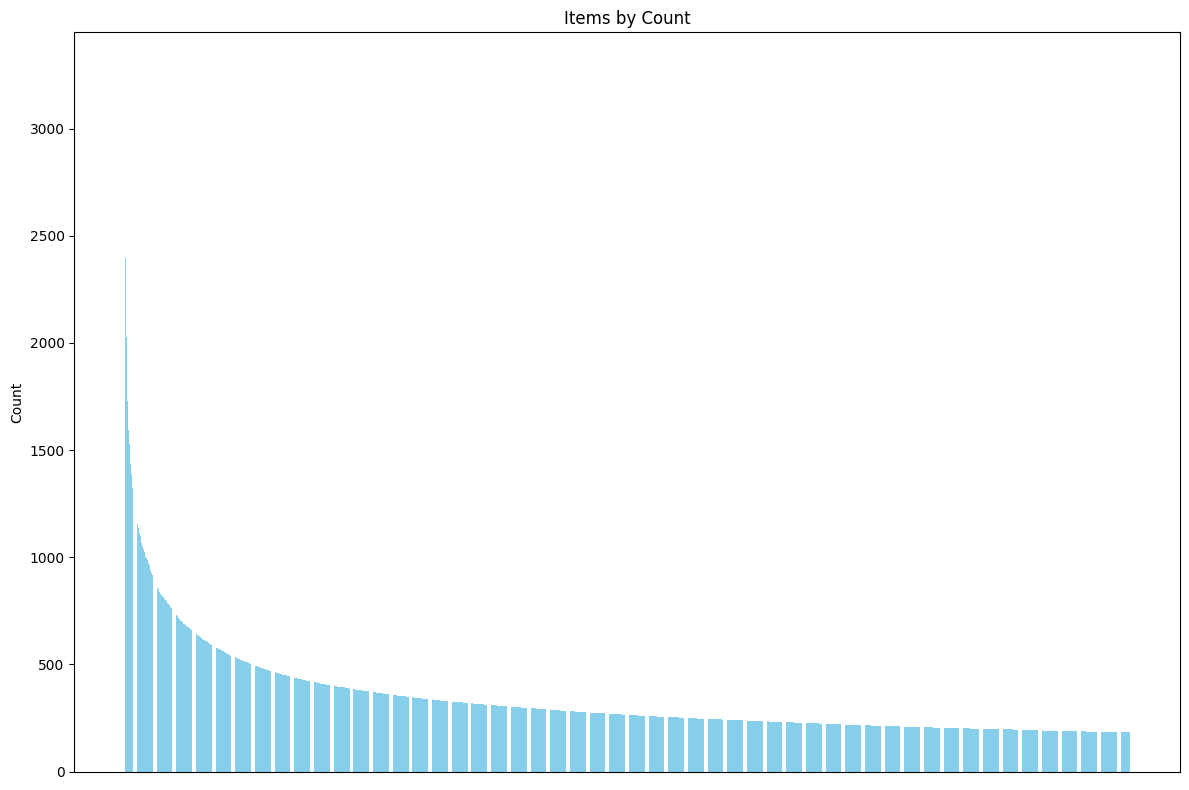

In [60]:
import matplotlib.pyplot as plt

# 假设sorted_result_pd已经是转换好的Pandas DataFrame
# 选择前100行
top_100 = sorted_result.head(10000)

plt.figure(figsize=(12, 8))  # 调整图形大小
plt.bar(range(len(top_100)), top_100['count'], color='skyblue')  # 使用索引作为x轴

plt.ylabel('Count')
plt.title('Items by Count')

# 清除x轴标签名
plt.xticks([])  # 设置为空列表，不显示任何x轴标签

plt.tight_layout()  # 自动调整子图参数, 使之填充整个图表区域
plt.show()


In [10]:
product = pl.read_parquet("/content/drive/MyDrive/kddcup2023-ly/kddcup2023/data/preprocessed/common/product_03.parquet")

In [11]:
co_visit_matrix = generate_co_visit_matrix(session_df, window_n=WINDOW_N, weights=WEIGHTS)

<ipython-input-6-eed425043d3b>:14: DeprecationWarning: `map_dict` is deprecated. It has been renamed to `replace`. The default behavior has changed to keep any values not present in the mapping unchanged. Pass `default=None` to keep existing behavior.
  pl.col("diff_sequence_num").map_dict(weights).alias("co_visit_weight")
<ipython-input-6-eed425043d3b>:16: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  df = df.groupby(["prev_items", "prev_items_right"]).sum()


In [ ]:
co_visit_matrix.head()

item,candidate_item,co_visit_weight
str,str,f64
"""B076THCGSG""","""B007MO8IME""",3.0
"""B001B4TKA0""","""B007MO8IME""",0.25
"""B007MO8IME""","""B08MF65MLV""",3.0
"""B076THCGSG""","""B001B4TKA0""",0.25
"""B09XMTWDVT""","""B0B4MZZ8MB""",922.41


In [ ]:
co_visit_matrix = filter_by_locale_availability(co_visit_matrix, product)

<ipython-input-7-56a96cf9c84c>:12: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  df = df.groupby("item", maintain_order=True).head(TOP_N)


In [ ]:
co_visit_matrix.head()

item,candidate_item,co_visit_weight,locale,co_visit_rank
str,str,f64,str,u32
"""0007440847""","""0008376107""",3.25,"""DE""",1
"""0007440847""","""3608937145""",0.5,"""DE""",2
"""0007440847""","""0261103563""",0.5,"""DE""",2
"""0007440847""","""3608938184""",0.5,"""DE""",2
"""0007440847""","""3608939849""",0.4,"""DE""",5


In [ ]:
file_name = f"co_visit_matrix_{VER}_for_train_or_eval.parquet"
co_visit_matrix.write_parquet("/content/drive/MyDrive/kddcup2023/data/interim/candidates/task1/" + file_name)

In [ ]:
co_visit_matrix.head()

item,candidate_item,co_visit_weight,locale,co_visit_rank
str,str,f64,str,u32
"""0007440847""","""0008376107""",3.25,"""DE""",1
"""0007440847""","""3608938184""",0.5,"""DE""",2
"""0007440847""","""0261103563""",0.5,"""DE""",2
"""0007440847""","""3608937145""",0.5,"""DE""",2
"""0007440847""","""3608939849""",0.4,"""DE""",5


## MRR@100

In [ ]:
train = pl.read_parquet("/content/drive/MyDrive/kddcup2023/data/preprocessed/task1/train_task1.parquet")

In [ ]:
# last_item
last_item_list = []
prev_items_list = train["prev_items"].to_list()
for prev_items in prev_items_list:
    last_item_list.append(prev_items[-1])
train = train.with_columns(pl.Series(name="last_item", values=last_item_list))

In [ ]:
train = train[["session_id", "locale", "last_item", "next_item"]]

In [ ]:
co_visit_matrix = pl.read_parquet("/content/drive/MyDrive/kddcup2023/data/interim/candidates/task1/" + file_name)

In [ ]:
# Merge candidate and add label
dfs = []
label_lists = []
for locale in LOCALES:
    df = train.filter(pl.col("locale")==locale)
    matrix = co_visit_matrix.filter(pl.col("locale")==locale)
    df = df.join(matrix, left_on=["locale", "last_item"], right_on=["locale", "item"], how="left")
    df = df.sort(["session_id", "co_visit_weight"], descending=[False, True])
    df = df.with_columns((pl.col("candidate_item") == pl.col("next_item")).cast(pl.Int8).alias("label"))
    label_lists.extend(df.groupby("session_id", maintain_order=True).all()["label"].to_list())

In [ ]:
# MRR
rr = 0
for labels in label_lists:
    labels = labels[:100]
    for i, label in enumerate(labels):
        if label == 1:
            rr += 1 / (i+1)
            break
mrr = rr / len(label_lists)
print("MRR:", round(mrr, 5))

MRR: 0.23472


# For test inference

In [ ]:
train1 = pl.read_parquet(DIR + "data/preprocessed/task1/train_task1.parquet")
train2 = pl.read_parquet(DIR + "data/preprocessed/task2/train_task2.parquet")
train1 = train1.with_columns(
    (pl.col("session_id") + "_from_task1").alias("session_id")
)
train = pl.concat([train1, train2])

test1_1 = pl.read_parquet(DIR + "data/preprocessed/task1/test_task1_phase1.parquet")
test1_2 = pl.read_parquet(DIR + "data/preprocessed/task1/test_task1_phase2.parquet")
test2_1 = pl.read_parquet(DIR + "data/preprocessed/task2/test_task2_phase1.parquet")
test2_2 = pl.read_parquet(DIR + "data/preprocessed/task2/test_task2_phase2.parquet")
test3_1 = pl.read_parquet(DIR + "data/preprocessed/task3/test_task3_phase1.parquet")
test3_2 = pl.read_parquet(DIR + "data/preprocessed/task3/test_task3_phase2.parquet")
test1_1 = test1_1.with_columns(
    (pl.col("session_id") + "_from_task1").alias("session_id")
)
test1_2 = test1_2.with_columns(
    (pl.col("session_id") + "_from_task1").alias("session_id")
)
test3_1 = test3_1.with_columns(
    (pl.col("session_id") + "_from_task3").alias("session_id")
)
test3_2 = test3_2.with_columns(
    (pl.col("session_id") + "_from_task3").alias("session_id")
)
test = pl.concat([test1_1, test1_2, test2_1, test2_2, test3_1, test3_2])

In [ ]:
# Append train's next_item to prev_items
prev_items_list = train["prev_items"].to_list()
next_item_list = train["next_item"].to_list()
prev_items_list_updated = []
for prev_items, next_item in zip(prev_items_list, next_item_list):
    prev_items.append(next_item)
    prev_items_list_updated.append(prev_items)

train = train.with_columns(
    pl.Series(name="prev_items", values=prev_items_list_updated)
)

In [ ]:
train = preprocess(train)
test = preprocess(test)
session_df = pl.concat([
    train["prev_items", "locale", "session_id", "sequence_num"],
    test["prev_items", "locale", "session_id", "sequence_num"],
])

In [ ]:
product = pl.read_parquet("/content/drive/MyDrive/kddcup2023/data/preprocessed/common/product_03.parquet")

In [ ]:
co_visit_matrix = generate_co_visit_matrix(session_df, window_n=WINDOW_N, weights=WEIGHTS)

In [ ]:
co_visit_matrix = filter_by_locale_availability(co_visit_matrix, product)

In [ ]:
file_name = f"co_visit_matrix_{VER}_for_inference.parquet"
co_visit_matrix.write_parquet("/content/drive/MyDrive/kddcup2023/data/interim/candidates/task1/" + file_name)

In [ ]:
co_visit_matrix.head()